Выполнила: Анастасия Плавина


# Предсказание статуса соискателя
на основе данных кандидатов ([Kaggle](https://www.kaggle.com/arashnic/hr-analytics-job-change-of-data-scientists))

## Этап 1. EDA

### 1. Цель проекта: 
Предсказать статус соискателя - находится ли человек в поиске работы или нет.

**Описание полей:**

- enrollee_id : Unique ID for candidate
- city: City code
- city_ development _index : Developement index of the city (scaled)
- gender: Gender of candidate
- relevent_experience: Relevant experience of candidate
- enrolled_university: Type of University course enrolled if any
- education_level: Education level of candidate
- major_discipline :Education major discipline of candidate
- experience: Candidate total experience in years
- company_size: No of employees in current employer's company
- company_type : Type of current employer
- lastnewjob: Difference in years between previous job and current job
- training_hours: training hours completed
- **target:** 0 – Not looking for job change, 1 – Looking for a job change

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import itertools

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint
%matplotlib inline

### 2. Загрузка данных

In [68]:
data = pd.read_csv("train.csv")
data.head(5)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [69]:
data.shape

(19158, 14)

In [70]:
data.dtypes

enrollee_id                 int64
city                       object
city_development_index    float64
gender                     object
relevent_experience        object
enrolled_university        object
education_level            object
major_discipline           object
experience                 object
company_size               object
company_type               object
last_new_job               object
training_hours              int64
target                    float64
dtype: object

### 3. Анализ целевой переменной

Посмотрим на соотношение классов:

Соотношение целевой переменной:
0 (not looking for a job - 75%
1 (looking for a job) - 25%


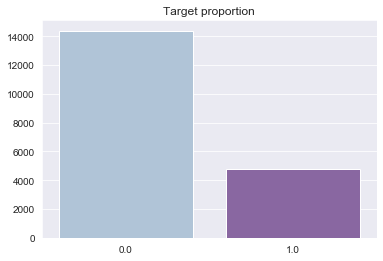

In [71]:
target = 'target'
features = data.columns.drop(target).tolist()

counts = data[target].value_counts()

print('Соотношение целевой переменной:')
print(f'0 (not looking for a job - {counts[0]/data.shape[0]*100:.0f}%')
print(f'1 (looking for a job) - {counts[1]/data.shape[0]*100:.0f}%')
  
plt.title('Target proportion')
sns.barplot(counts.index, counts.values, palette='BuPu')
plt.show()

Вывод: есть существенный дисбаланс классов.

### 4. Анализ признаков

In [72]:
data.columns

Index(['enrollee_id', 'city', 'city_development_index', 'gender',
       'relevent_experience', 'enrolled_university', 'education_level',
       'major_discipline', 'experience', 'company_size', 'company_type',
       'last_new_job', 'training_hours', 'target'],
      dtype='object')

In [73]:
continuous_columns = list(data.drop(target, axis=1).select_dtypes(['float', 'int']).columns)
continuous_columns

['enrollee_id', 'city_development_index', 'training_hours']

In [74]:
categorical_columns = list(data.select_dtypes('object').columns)

#### Категориальные признаки

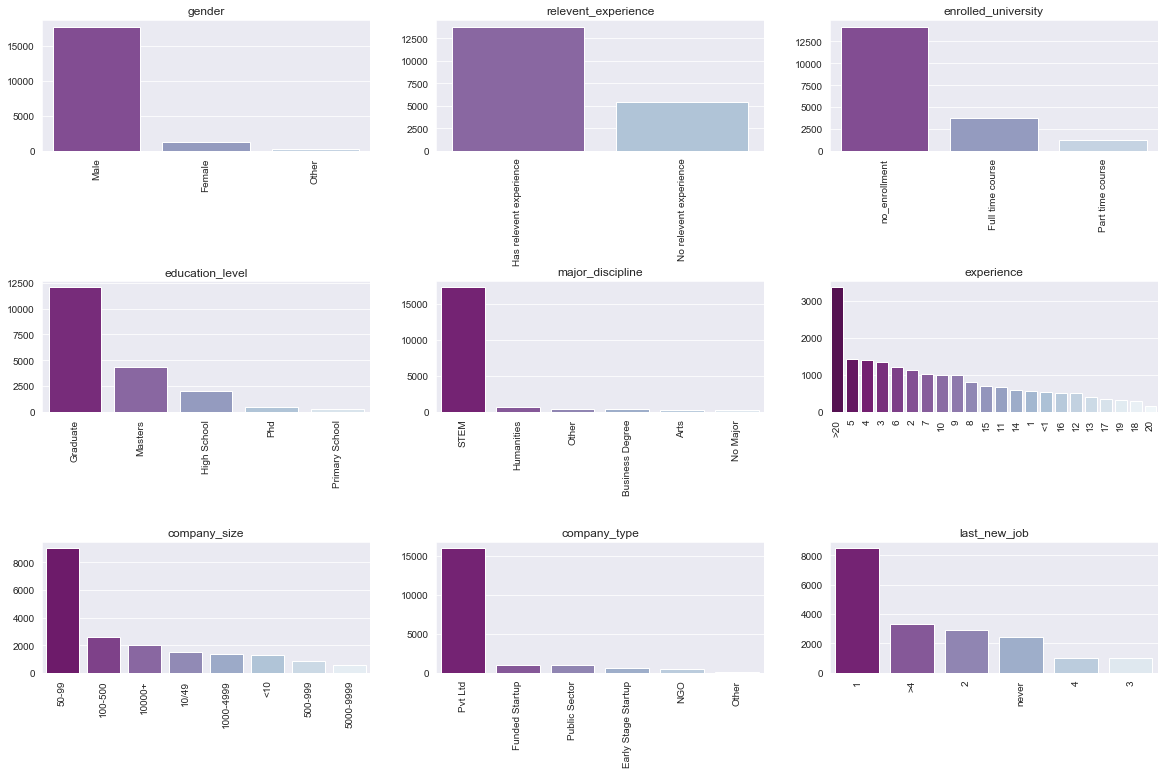

In [107]:
# посмотрим без city 

fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(20, 12))

for i, ax in enumerate(axes.flat):
    counts = data[categorical_columns[1:][i]].value_counts()
    sns.barplot(counts.index, counts.values, ax=ax, palette='BuPu_r')
    
    ax.set_title(categorical_columns[1:][i])
    ax.tick_params(axis='x', labelrotation=90)

plt.subplots_adjust(hspace = 1)
plt.show()

Видим, что можно перевести некоторые признаки в int и сделать бинарные признаки - есть образование, нет образования, есть опыт, нет опыта

#### Анализ пропусков

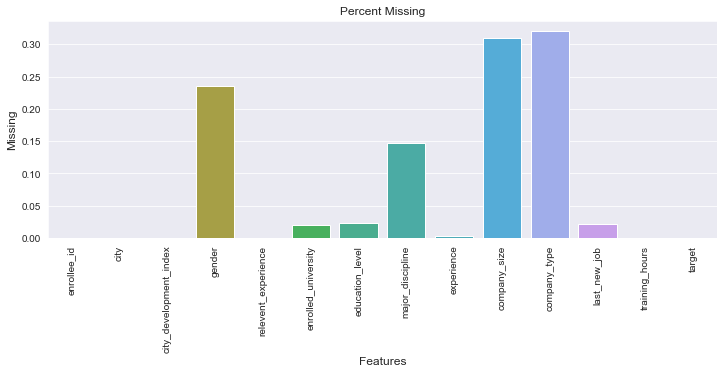

In [76]:
nan_df = (data.isna().sum() / data.shape[0]).reset_index()
nan_df.columns=['feature', 'nan_percent']

plt.figure(figsize=(12,4))
sns.barplot(nan_df['feature'], nan_df['nan_percent'])
plt.title('Percent Missing')
plt.ylabel('Missing', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=90)
plt.show()


Пропусков достаточно много, будем делать доп. колонки

In [77]:
#### Заменяем пропуски на моды и делаем колонки для нанов
nan_cols = ['gender', 'enrolled_university', 'education_level', 'major_discipline', 
            'experience', 'company_size', 'company_type', 'last_new_job'] 

for feat in nan_cols:
    data[feat+'_is_nan'] = 0
    na_index = data[data[feat].isna()].index
    data[feat].fillna(data[feat].mode()[0], inplace=True)
    for i in na_index:
        data[feat+'_is_nan'].iloc[i] = 1

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


#### Количественные признаки

In [78]:
# посмотрим на оцифрованный опыт
data['experience_int'] = data['experience']
data.loc[data['experience'] == '>20', 'experience_int'] = 25
data.loc[data['experience'] == '<1', 'experience_int'] = 0
data['experience_int'] = data['experience_int'].astype(int)

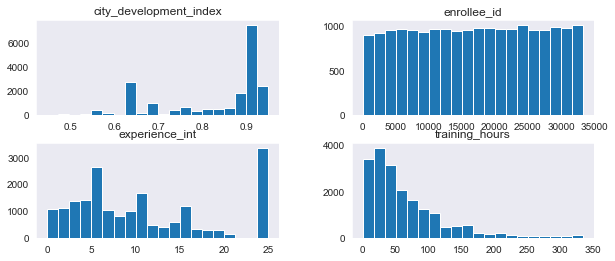

In [79]:
data[continuous_columns + ['experience_int']].hist(figsize=(10,4), bins=20, grid=False)
plt.show()

#### Проверяем распределение таргета по категориальным признакам

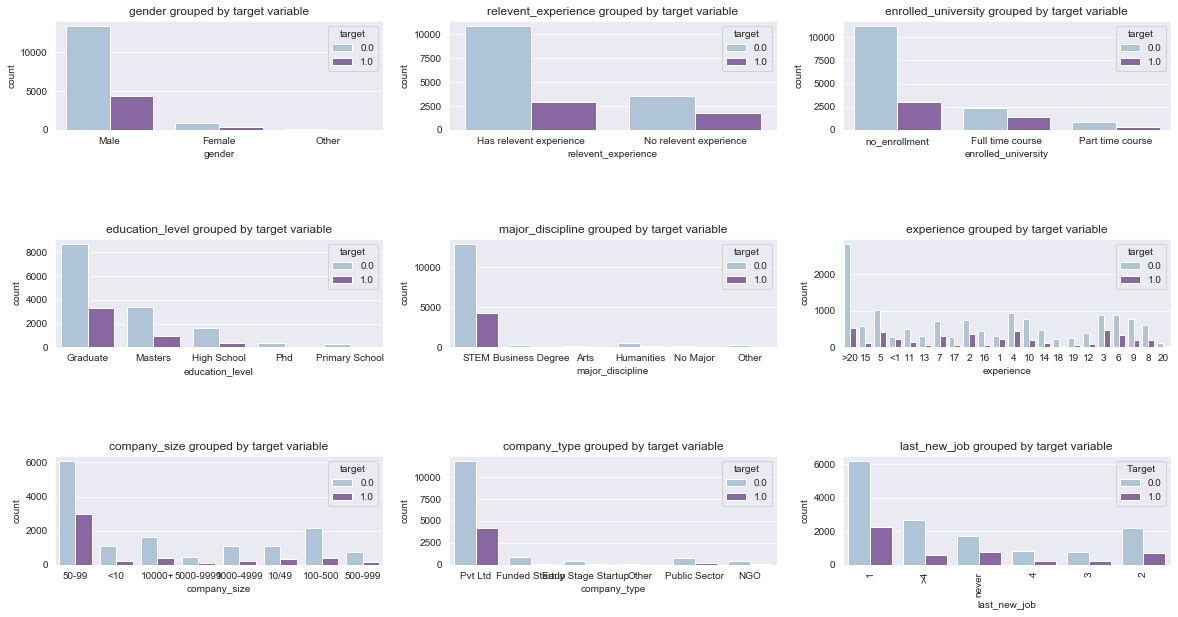

In [111]:
# посмотрим без city 

fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(20, 10))

for i, ax in enumerate(axes.flat):
    sns.countplot(x=categorical_columns[1:][i], hue=target, data=data, ax=ax, palette='BuPu')
    ax.set_title(f'{categorical_columns[1:][i]} grouped by target variable')

plt.legend(title='Target', loc='upper right')
plt.tick_params(axis='x', labelrotation=90)
plt.subplots_adjust(hspace = 1)
plt.show()

In [61]:
def contingency_test(df, feature):
    feat_values = df[feature].unique()
    important_cols = []
    for item in itertools.combinations(feat_values, 2):
        if df[df[feature]==item[0]].shape[0] < 500 and df[df[feature]==item[1]].shape[0] < 500:
            continue
            
        
        feature_and_target_s = df.loc[df[feature].isin(list(item)), \
                                         [feature, target]].sample(500)
        
        feature_and_target_s['id'] = pd.Index(range(500))

        table = feature_and_target_s.pivot_table(values='id', index=feature, columns=target, 
                                                        aggfunc='count')
        
        chi2, p, dof, expected = chi2_contingency(table, correction=False)
        
        if p != p: # если nan
            continue
        if p < 0.05:
            important_cols.append(feature)
            
    if len(important_cols) > 0:
        print(f'В {set(important_cols)} есть несогласованные частоты')


In [64]:
for col in categorical_columns[1:]:
    contingency_test(data, col)

В {'relevent_experience'} есть несогласованные частоты
В {'enrolled_university'} есть несогласованные частоты
В {'education_level'} есть несогласованные частоты
В {'experience'} есть несогласованные частоты
В {'company_size'} есть несогласованные частоты
В {'company_type'} есть несогласованные частоты
В {'last_new_job'} есть несогласованные частоты


В данных признаках есть потенциал по разделению классов, т.к. в них есть несогласованные частоты по количеству уникальных значений.

#### Проверяем значимость распредлений вещественных признаков для таргета

In [ ]:
def dist_checker(df, feature):

    feature_with_target_s = df[[feature, target]].sample(1000)
    feature_s = feature_with_target_s[feature]
    feature_target_0 = feature_s[feature_with_target_s[target] == 0]
    feature_target_1 = feature_s[feature_with_target_s[target] == 1]
    norm_test = shapiro(feature_s)[1]
    # проверяем на нормальность
    if norm_test > 0.05:
        print('Distribution is normal')
    else:
        print('Distribution is not normal')
        u_test = mannwhitneyu(feature_target_0, feature_target_1)[1]
        if u_test > 0.05:
            print('H0 нельзя отвергнуть, считаем, что мат.ожидания равны')
        else:
            print('H0 нельзя принять, считаем, что мат.ожидания не равны')
            

    fig, axes = plt.subplots(1, 2, figsize=(20, 6))

    # 0 -Not looking for job change, 1 – Looking for a job change
    sns.kdeplot(feature_target_0, shade=True, label='Not looking for job change,', color='g', ax=axes[0])
    sns.kdeplot(feature_target_1, shade=True, label='Looking for a job change', color='r', ax=axes[0])
    plt.xlabel(f'{feature}')
    plt.title(f'{feature} distribution grouped by target variable')
    
    
    sns.pointplot(x=target, y=feature, data=feature_with_target_s, capsize=.1, ax=axes[1])
    plt.title(f'Confidence intervals (95 %) for {feature}')

    
    plt.show()

---------------------------enrollee_id--------------------
Distribution is not normal
H0 нельзя отвергнуть, считаем, что мат.ожидания равны


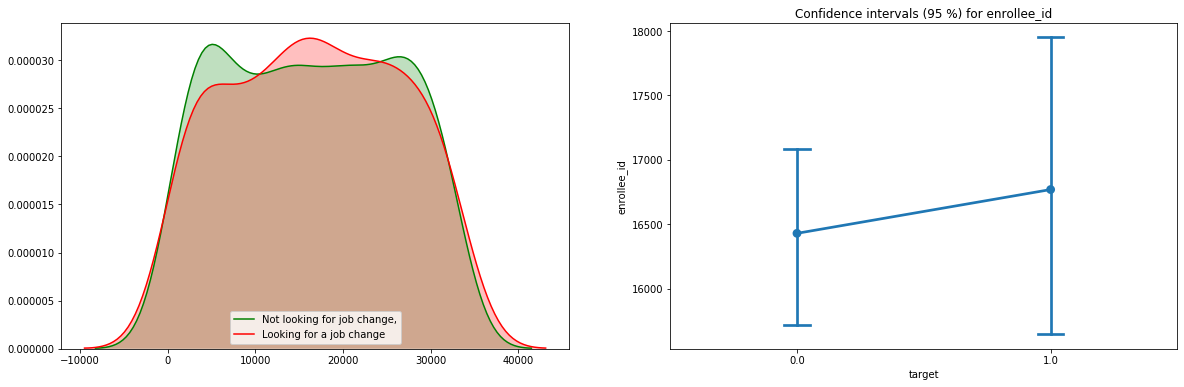

---------------------------city_development_index--------------------
Distribution is not normal
H0 нельзя принять, считаем, что мат.ожидания не равны


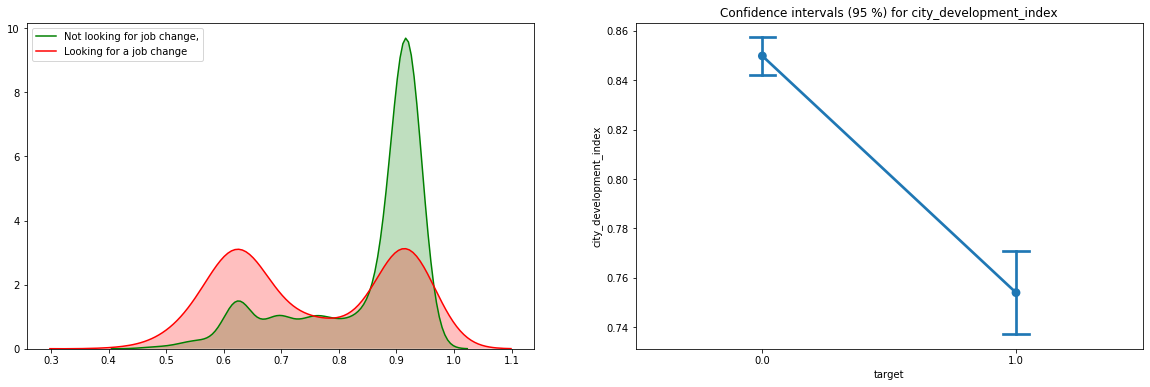

---------------------------training_hours--------------------
Distribution is not normal
H0 нельзя отвергнуть, считаем, что мат.ожидания равны


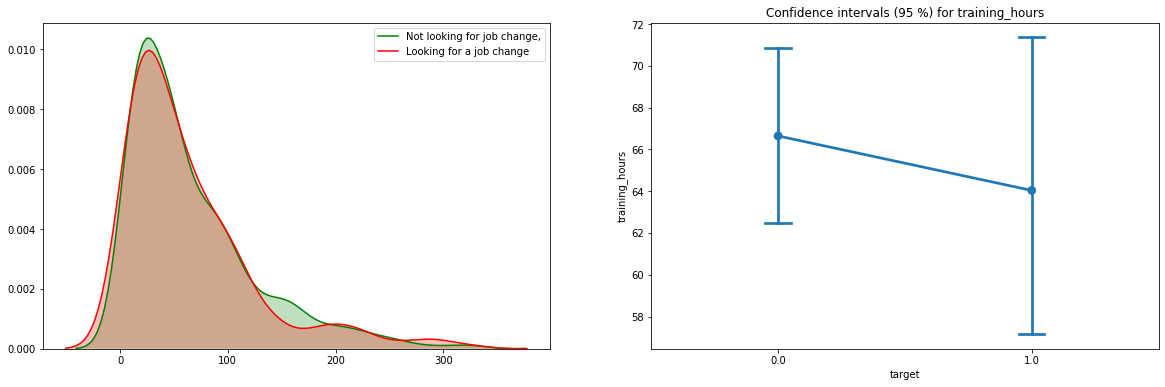

---------------------------experience_int--------------------
Distribution is not normal
H0 нельзя принять, считаем, что мат.ожидания не равны


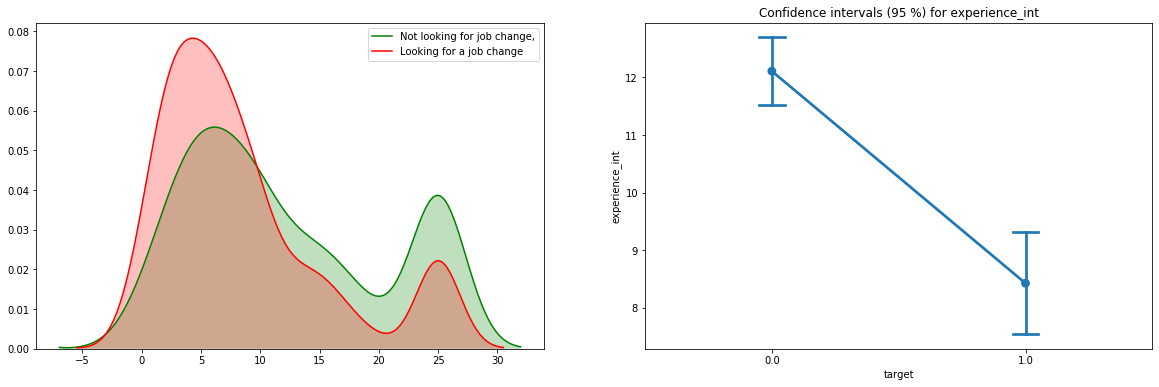

In [16]:
for col in continuous_columns + ['experience_int']:
    print(f'---------------------------{col}--------------------')
    dist_checker(data, col)
    

Вывод: видим, что есть значимое различие распредлений по признаку city development index - есть два пика по классу "находится в поиске работы" на значении индекса от 0.5 до 0.7 и от 0.85 до 1.

Так же есть потенциал разделению по продолжительности опыта работы.

#### Матрица корреляций

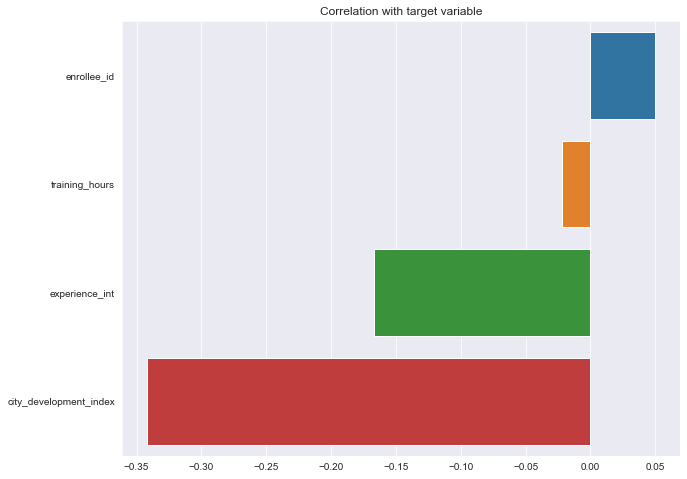

In [114]:
corr_with_target = data[features + ['experience_int'] + [target]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

Вывод: снова находим подтверждение важности признака индекса развития города, а также обратную корреляцию от индекса и опыта (чем выше развитие и больше опыта, тем меньше мероятность желания смены работы), есть небольшая корреляция от id (то есть есть предположение, что пополнение базы кандидатов может влиять на статус соискателя - забегая вперед, в модели он правда дает улучшение).